1715
1715


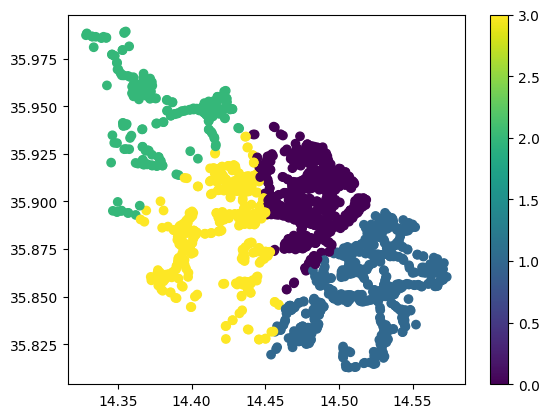

In [13]:
%run ./DFBRP_Simulator_Clusters.ipynb

In [14]:
import json
import math
import numpy as np
from datetime import timedelta
from scipy import stats

In [15]:
from datetime import datetime

# start time
start_time = "2:13:57"
end_time = "11:46:38"

# convert time string to datetime
t1 = datetime.strptime(start_time, "%H:%M:%S")
print('Start time:', t1.time())

t2 = datetime.strptime(end_time, "%H:%M:%S")
print('End time:', t2.time())

# get difference
delta = t2 - t1

# time difference in seconds
print(f"Time difference is {delta.total_seconds()} seconds")

# time difference in milliseconds
ms = delta.total_seconds() * 1000
print(f"Time difference is {ms} milliseconds")

Start time: 02:13:57
End time: 11:46:38
Time difference is 34361.0 seconds
Time difference is 34361000.0 milliseconds


In [16]:
REJECTED = 0
ACCEPTED = 1
ORIGIN_INDEX = 1
DESTINATION_INDEX = 2
BUS_STOP_DATA_PATH = "./Data/bus_stops.json"
REWARD_PER_PASSENGER = 100
POSITIVE_LOAD_REWARD = 50

class GymDFBRPSimulator(DFBRPSimulator):
    def __init__(self, numberOfBuses,numberOfRequests,rendermode=None):
        super().__init__(numberOfBuses,numberOfRequests,render_mode=rendermode)
        self.numberOfBuses = numberOfBuses
        self.numberOfRequests = numberOfRequests
        self.smallestLatitude,self.smallestLongitude,self.largestLatitude,self.largestLongitude = self._findBoundariesCords()

        self.previousRewardDistance = 0
        self.previousRewardWaitingTime = 0

        if rendermode =="human":
            self.initMap()

    def _findBoundariesCords(self):
        boundaries = MAP_BOUNDARIES
        lat1 = boundaries[0]
        lon1 = boundaries[1]
        lat2 = boundaries[2]
        lon2 = boundaries[3]

        smallestLat = min(lat1,lat2)
        smallestLon = min(lon1,lon2)
        largestLat = max(lat1,lat2)
        largestLon = max(lon1,lon2)
        return smallestLat,smallestLon,largestLat,largestLon
    
    #Observation Functions
    def getRequestObservation(self):
        #Create an np array of the following format:
        # [requestLocationLatitude,requestLocationLongitude, requestDestinationLatitude,requestDestinationLongitude, requestPassengerCount]
        request = self.currentRequest
        origin = request.getOrigin()
        destination = request.getDestination()
        requestObservation = np.array([origin.getLatitude()-self.smallestLatitude,origin.getLongitude()-self.smallestLongitude,destination.getLatitude()-self.smallestLatitude,destination.getLongitude()-self.smallestLongitude,request.getPassengerAmount(),request.getCluster()], dtype=np.float32)
        return requestObservation 
    def getBusesLocationsObservation(self):
        busesLocations = np.zeros((self.numberOfBuses,2), dtype=np.float32)
        for i,vehicle in enumerate(self.vehicles):
            location = vehicle.getPosition()
            busesLocations[i] = [location.getLatitude()-self.smallestLatitude,location.getLongitude()-self.smallestLongitude]
        assert busesLocations.shape == (self.numberOfBuses,2)
        return busesLocations    
    def getPassengerCountsObservation(self):
        passengerCounts = np.zeros((self.numberOfBuses), dtype=np.int8)
        for i,vehicle in enumerate(self.vehicles):
            passengerCounts[i] = vehicle.getCurrentLoad()
        assert passengerCounts.shape == (self.numberOfBuses,)
        return passengerCounts  
    def getBusesRoutesObservation(self):
        busesRoutes = np.zeros((self.numberOfBuses,self.getCapacity()*2,2), dtype=np.float32)
        for i in range(self.numberOfBuses):
            busesRoutes[i] = self._getBusRoute(i)
        return busesRoutes
    def getBusesDistancesObservation(self):
        busesDistances = np.zeros((self.numberOfBuses), dtype=np.float32)
        for i,vehicle in enumerate(self.vehicles):
            busesDistances[i] = vehicle.getRouteDistance()
        return busesDistances
    
    #MISC FUNCTIONS
    def getCapacity(self):
        return self.vehicles[0].getCapacity()
    def _getBusRoute(self, index):
        route = self.vehicles[index].getListOfCords()
        npRoute = np.zeros((self.getCapacity()*2,2), dtype=np.float32)
        if route != None:
            for i in range(len(route)):
                npRoute[i] = [route[i].getLatitude()-self.smallestLatitude,route[i].getLongitude()-self.smallestLongitude]
        return npRoute
    #REWARD FUNCTION
    def getPreStepReward(self):
        distanceReward = []
        waitingTimeReward = []
        broken = self.getTimeWindowsReward()
        for vehicle in self.vehicles:
            distanceReward.append(vehicle.getRouteDistance()/1000)
            waitingTimeReward.append(vehicle.getRequestWaitingTime()/60)
        return distanceReward,broken
    def getTimeWindowsReward(self):
        rewardList = []
        for vehicle in self.vehicles:
            timeWindowsReward = 0
            if vehicle.getRouteSize() == 0:
                rewardList.append(0)
                continue
            currentTime = self.currentRequest.getTime()
            route = vehicle.getRequestOSRMJSON()
            for i in range(len(route["routes"][0]["legs"])):
                leg = route["routes"][0]["legs"][i]
                legDistance = leg["distance"]
                duration = legDistance/vehicle.speed
                currentTime = timedelta(seconds=duration) + currentTime 
                timeWindow = vehicle.routeList[i].getTimeWindow()
                timeDiff = (((timeWindow - currentTime).total_seconds())/60)
                if timeDiff < 0:
                    timeDiff = -1*(timeDiff*timeDiff)
                # print("current time: "+str(currentTime) + " time window: "+str(timeWindow) + " time diff: "+str(timeDiff))
                timeWindowsReward += timeDiff
            rewardList.append(timeWindowsReward)
        return rewardList

    def getReward(self,action,lastagent,prevDistance,prevBrokenTimeWindows):
        rewards = []
        acceptedReward = np.zeros((self.numberOfBuses), dtype=np.float32)

        if action == REJECTED:
            totalReward = self.currentRequest.getPassengerAmount()*(REWARD_PER_PASSENGER)*-1*(len(self.rejectedRequests))
            for i in range(len(self.vehicles)):
                if int(self.vehicles[i].getCluster()) == int(self.currentRequest.getCluster()):
                    acceptedReward[i] = totalReward

        broken = self.getTimeWindowsReward()
        brokenRewards = {}
        for i in range(self.clusterAmount):
            brokenRewards[i] = 0
        for i in range(len(self.vehicles)):
            brokenRewards[self.vehicles[i].getCluster()] += broken[i]
        for i in range(len(self.vehicles)):
            reward = 0
            reward += acceptedReward[i]
            reward += brokenRewards[self.vehicles[i].getCluster()]
            rewards.append(reward)

        print(str(acceptedReward) + " + " + str(brokenRewards) + " = " + str(rewards))
        return rewards                

    def reset(self):
        self.vehicles = self.initVehicles(self.numberOfBuses)
        self.requests = self.initRequests(self.numberOfRequests)
        self.currentRequest = self.requests[0]
        self.currentRequestIndex = 0
        self.rejectedRequests = []
        self.handledRequest = False
        if self.render_mode == "human":
            self._updateMap()
    def getSmallestLongitude(self):
        return self.smallestLongitude
    def getSmallestLatitude(self):
        return self.smallestLatitude
    def getLargestLongitude(self):
        return self.largestLongitude
    def getLargestLatitude(self):
        return self.largestLatitude

In [17]:
test = GymDFBRPSimulator(5,50)
print(test.clusterAmount)

4


In [18]:
import time as ts
d1 = GymDFBRPSimulator(10,50,rendermode="human")

for i in range(0):
    index = i%10
    d1.acceptRequest(index,len(d1.vehicles[index].routeList),len(d1.vehicles[index].routeList)+1)
    d1.advanceToNextRequest()
    previousDistance,previousWaitingTime = d1.getPreStepReward()
    print("Reward:",d1.getReward(ACCEPTED,previousDistance,previousWaitingTime))
    d1.updateState()
    print("RouteList",len(d1.vehicles[0].routeList))
    ts.sleep(1)

In [19]:
# a = -200
# b = -2200
# aa = 200
# bb = -2200
# d = (a - b)*-1
# dd = (aa - bb)*-1
# print(d)
# print(dd)